This notebook is used to support the ORKG-related statements made in the paper
<br><br>
<center>
"Examining the ORKG towards Representation of Control Theoretic Knowledge – Preliminary Experiences and Conclusions"

</center>
    
(currently under review).

Note: every SPARQL-Query can also be run via the web interface <https://www.orkg.org/orkg/sparql/>.

In [109]:
import time
print(time.ctime())
%load_ext ipydex.displaytools

Fri Feb 25 00:43:12 2022
The ipydex.displaytools extension is already loaded. To reload it, use:
  %reload_ext ipydex.displaytools


In [50]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

sparql = SPARQLWrapper("https://www.orkg.org/orkg/triplestore/")
sparql.setReturnFormat(JSON)

prefixes = """
PREFIX orkgr: <http://orkg.org/orkg/resource/>
PREFIX orkgc: <http://orkg.org/orkg/class/>
PREFIX orkgp: <http://orkg.org/orkg/predicate/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

"""

**Claim:**  At the time of writing, the ORKG SPARQL query service lists
101218 distinct nodes (excluding literal values) and 4699 properties.


In [45]:
qs = """
SELECT  (COUNT(distinct ?vertex) AS ?count)
WHERE
{
  {
    ?vertex ?p []
  }
  UNION
  {
    [] ?p ?vertex
    FILTER(!IsLiteral(?vertex))
  }
}
"""

sparql.setQuery(qs)
ans = sparql.query().convert()
q = ans["results"]["bindings"] ##:

q := [{'count': {'type': 'typed-literal',
   'datatype': 'http://www.w3.org/2001/XMLSchema#integer',
   'value': '101218'}}]

---

In [44]:
qs = """
SELECT  (COUNT(distinct ?p) AS ?count)
WHERE
{
  {
    ?vertex ?p []
  }
  UNION
  {
    [] ?p ?vertex
    FILTER(!IsLiteral(?vertex))
  }
}
"""

sparql.setQuery(qs)
ans = sparql.query().convert()
q = ans["results"]["bindings"] ##:

q := [{'count': {'type': 'typed-literal',
   'datatype': 'http://www.w3.org/2001/XMLSchema#integer',
   'value': '4699'}}]

---

---

**Claim:**  At the time of writing, the ORKG SPARQL query service lists
101218 distinct nodes (excluding literal values) and 4699 properties.


In [ ]:
with open("dump.nt") as thefile:
    lines = thefile.readlines()
    
print(len(lines))
new_lines = []
for l in lines:
    if "<null>" in l:
        continue
    new_lines.append(l)

---

**Claim:** At the beginning of this study (2022-01-15) there are five papers
listed under research field Control Theory (R109).


In [60]:
qs = prefixes + """
select distinct ?paper ?title where
  {?paper orkgp:P30 orkgr:R109;
          rdfs:label ?title;
          rdf:type ?type.
  MINUS { ?paper rdf:type orkgc:PaperDeleted . }
  }
"""

sparql.setQuery(qs)
ans = sparql.query().convert()
q = ans["results"]["bindings"]

In [61]:
flat_result_list = [{k: v["value"] for k, v in row.items()} for row in q]
pd.DataFrame(flat_result_list)

,paper,title
0,http://orkg.org/orkg/resource/R138527,Sensitivity analysis applied to a variational ...
1,http://orkg.org/orkg/resource/R138532,Incremental projection approach of regularizat...
2,http://orkg.org/orkg/resource/R146945,Design and In Silico Evaluation of a Closed-Lo...
3,http://orkg.org/orkg/resource/R146974,Data-Enabled Predictive Control: In the Shallo...
4,http://orkg.org/orkg/resource/R146978,Data-Driven Model Predictive Control With Stab...


---

**Claim:** The control-theoretic papers have between 1 and five associated (via `P32`) research problems.


In [76]:
qs = prefixes + """
SELECT distinct ?paper ?title ?rpLabel WHERE
{
  ?paper orkgp:P30 orkgr:R109;
          rdfs:label ?title;
          rdf:type ?type.
  ?paper orkgp:P31 ?ctrb.  # contribution
  ?ctrb orkgp:P32 ?rp.     # research problems
  ?rp rdfs:label ?rpLabel.
  MINUS { ?paper rdf:type orkgc:PaperDeleted . }

}
"""

sparql.setQuery(qs)
ans = sparql.query().convert()
q = ans["results"]["bindings"]
flat_result_list = [{k: v["value"] for k, v in row.items()} for row in q]
pd.DataFrame(flat_result_list)

,paper,title,rpLabel
0,http://orkg.org/orkg/resource/R138527,Sensitivity analysis applied to a variational ...,Adjoint based sensitivity
1,http://orkg.org/orkg/resource/R138532,Incremental projection approach of regularizat...,L2 Regularization
2,http://orkg.org/orkg/resource/R146945,Design and In Silico Evaluation of a Closed-Lo...,Adaptive control of fluid resuscitation
3,http://orkg.org/orkg/resource/R146945,Design and In Silico Evaluation of a Closed-Lo...,modeling blood pressure response to infusion a...
4,http://orkg.org/orkg/resource/R146945,Design and In Silico Evaluation of a Closed-Lo...,automatic resusictation therapy
5,http://orkg.org/orkg/resource/R146945,Design and In Silico Evaluation of a Closed-Lo...,closed-loop fluid resuscitation
6,http://orkg.org/orkg/resource/R146945,Design and In Silico Evaluation of a Closed-Lo...,In-silico evaluation of closed-loop controllers
7,http://orkg.org/orkg/resource/R146945,Design and In Silico Evaluation of a Closed-Lo...,closed-loop control of hemorrhage resusication
8,http://orkg.org/orkg/resource/R146974,Data-Enabled Predictive Control: In the Shallo...,data-driven predictive control using input-out...
9,http://orkg.org/orkg/resource/R146978,Data-Driven Model Predictive Control With Stab...,data-driven predictive control using input-out...


---

**Claim:**  Of these ten research problems two posses a description (via orkgp:description)


In [85]:
qs = prefixes + """
SELECT distinct ?rpLabel ?predicate ?obj WHERE
{
  ?paper orkgp:P30 orkgr:R109;
          rdfs:label ?title;
          rdf:type ?type.
  ?paper orkgp:P31 ?ctrb.  # contribution
  ?ctrb orkgp:P32 ?rp.     # research problems
  ?rp rdfs:label ?rpLabel.
  ?rp ?predicate ?obj.
  
  MINUS {
  ?paper rdf:type orkgc:PaperDeleted.
  }
  
  FILTER(?predicate !=  rdf:type )
  FILTER(?predicate !=  rdfs:label )

}
"""

sparql.setQuery(qs)
ans = sparql.query().convert()
q = ans["results"]["bindings"]
flat_result_list = [{k: v["value"] for k, v in row.items()} for row in q]
pd.DataFrame(flat_result_list)

,rpLabel,predicate,obj
0,Adjoint based sensitivity,http://orkg.org/orkg/predicate/description,sensitivity analysis; variational data assimil...
1,data-driven predictive control using input-out...,http://orkg.org/orkg/predicate/description,The predictive model in the predictive control...


In [88]:
for r in flat_result_list:
    print(f"description of research problem '{r['rpLabel']}':\n'{r['obj']}'\n\n")

description of research problem 'Adjoint based sensitivity':
'sensitivity analysis; variational data assimilation; adjoint method; pollution; optimal control;
inverse problem'


description of research problem 'data-driven predictive control using input-output data':
'The predictive model in the predictive control problem is now replaced by a set of input/output data matrices'




---

**Claim:**  All together there are 29 statements associated with the five contributions, and the by far most frequently used property is the just mentioned `has research problem` (`P32`, 14 times).

In [96]:
qs = prefixes + """
SELECT distinct ?property ?propertyLabel (COUNT(?property) AS ?propertyCount)
WHERE
{
  ?paper orkgp:P30 orkgr:R109.
  ?paper orkgp:P31 ?ctrb.  # contribution
  ?ctrb ?property ?obj.     # any relation of the contribution to some object
  ?property rdfs:label ?propertyLabel

  FILTER(?property != rdfs:label)
  FILTER(?property != rdf:type)

}
GROUP BY ?property ?propertyLabel
ORDER BY DESC(?propertyCount)
"""

sparql.setQuery(qs)
ans = sparql.query().convert()
q = ans["results"]["bindings"]
flat_result_list = [{k: v["value"] for k, v in row.items()} for row in q]
df = pd.DataFrame(flat_result_list) ##:

,property,propertyLabel,propertyCount
0,http://orkg.org/orkg/predicate/P32,has research problem,14
1,http://orkg.org/orkg/predicate/P41907,Mathematical model,2
2,http://orkg.org/orkg/predicate/P41911,Theoretical guarantees,2
3,http://orkg.org/orkg/predicate/P41912,Robustness analysis,2
4,http://orkg.org/orkg/predicate/P21,programming language,2
5,http://orkg.org/orkg/predicate/P41909,Mathematical model used In-silico study,2
6,http://orkg.org/orkg/predicate/P35214,Has example,2
7,http://orkg.org/orkg/predicate/P41908,Experimental validation of mathematical model,2
8,http://orkg.org/orkg/predicate/P41910,In-vivo study,1


---

In [108]:
df["propertyCount"].astype(int).sum()

29

**Note:** This query does not yet exclude deleted papers. This should be corrected in the revised version.

---

**Claim:** `Has example` (`P35214`) is used for two papers/contributions and has litera string values.

In [114]:
qs = prefixes + """
SELECT distinct ?title ?propertyLabel ?pvalue
WHERE
{
  ?paper orkgp:P30 orkgr:R109;
         rdfs:label ?title.
  ?paper orkgp:P31 ?ctrb.  # contribution
  
  ?ctrb ?property ?pvalue.
  VALUES ?property {orkgp:P35214}.  
  ?property rdfs:label ?propertyLabel.
}
"""

sparql.setQuery(qs)
ans = sparql.query().convert()
q = ans["results"]["bindings"]
flat_result_list = [{k: v["value"] for k, v in row.items()} for row in q]
idx = np.flatnonzero(data["fieldLabel"] == "Control Theory")[0]
paper_count = (data["paperCount"]).to_numpy() ##:) ##:

,title,propertyLabel,pvalue
0,Data-Enabled Predictive Control: In the Shallo...,Has example,yes - quadcoptor
1,Data-Driven Model Predictive Control With Stab...,Has example,yes - four tank system


---

---

**Claim:**  With five associated papers control theory is in the center field of the ordered list of all research fields.

In [115]:
qs = prefixes + """
SELECT ?field ?fieldLabel (COUNT(?paper) AS ?paperCount)
WHERE {
  ?paper a orkgc:Paper. # ... is a paper
  ?paper orkgp:P30 ?field.
  ?paper rdfs:label ?title.
  ?field rdfs:label ?fieldLabel.

}
GROUP BY ?field ?fieldLabel
ORDER BY DESC(?paperCount)
LIMIT 1000
"""
sparql.setQuery(qs)
ans = sparql.query().convert()
q = ans["results"]["bindings"]

In [117]:
flat_result_list = [{k: v["value"] for k, v in row.items()} for row in q]

In [128]:
df = pd.DataFrame(flat_result_list)
idx = np.flatnonzero(df["fieldLabel"] == "Control Theory")[0]
paper_count = (df["paperCount"]).astype(int).to_numpy() ##:i

info(paper_count) := "<class 'numpy.ndarray'> with shape: (228,)"

---

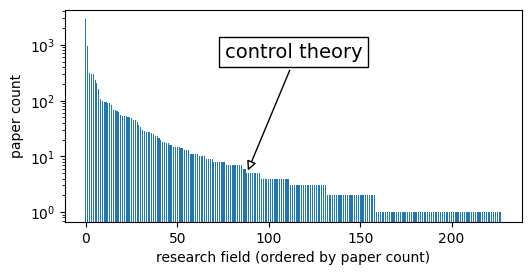

In [129]:
mm = 1/25.4 # mm to inch
scale = 2
fs = [75*mm*scale, 35*mm*scale]
plt.figure(figsize=fs, dpi=100)
n_fields = len(paper_count)
plt.bar(np.arange(n_fields), paper_count, width=0.6)
ax = plt.gca()
ax.set_yscale('log')
plt.ylabel("paper count")
plt.xlabel("research field (ordered by paper count)")


ann = ax.annotate("control theory",
                  xy=(idx, 5), xycoords='data',
                  xytext=(0.5, 0.8), textcoords='axes fraction',
                  size=14, va="center", ha="center",
                  bbox=dict(boxstyle="Square", fc="w"),
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle="arc3,rad=0.0",
                                  relpos=(0.5, 0.),
                                  fc="w"),
                  )


plt.show()